In [23]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt
import seaborn as sns


### 데이터셋 구축

In [27]:
IMAGE_ROOT ="./data/train/DCM"
LABEL_ROOT = "./data/train/outputs_json"

In [28]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [29]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}
print('png 개수: ' ,len(pngs))

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}
print('jsons 개수: ' ,len(jsons))

pngs = sorted(pngs)
jsons = sorted(jsons)


png 개수:  800
jsons 개수:  800


### segmentataion 이미지 관련 데이터셋 구축

In [30]:
class XRayDataset(Dataset):
    def __init__(self):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)

        self.filenames = _filenames
        self.labelnames = _labelnames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = image / 255.

        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)

        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]

        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])

            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label

        image = image.transpose(2, 0, 1) 
        label = label.transpose(2, 0, 1)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()

        return image, label

dataset = XRayDataset()


### json 관련 데이터셋 구축

In [31]:
jsons_files = list(jsons)
pngs_files = list(pngs)  

data_list =[]
annotations_list = []


for json_file, png_file in zip(jsons_files, pngs_files):
    with open(os.path.join(LABEL_ROOT, json_file), 'r') as file:
        data = json.load(file)
        data['image_path'] = png_file
        data_list.append(data)

df = pd.DataFrame(data_list)


In [32]:
df.head()

,annotations,attributes,file_id,filename,parent_path,last_modifier_id,metadata,last_workers,image_path
0,[{'id': '30-f037db6e-aef2-4156-93e2-8de7cc9786...,{},637ef14e41c1bfb2ef9029e7,image1661130828152_R.jpg,/X-ray_UNIST/20220822/ID001,5fa0b605a7b2076fa9f84c80,"{'height': 3060, 'width': 3060}","{'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None...",ID001\image1661130828152_R.png
1,[{'id': '2-c2f2929f-410f-4043-a27e-93b875366d7...,{},637ef14f301f58bb7963588f,image1661130891365_L.jpg,/X-ray_UNIST/20220822/ID001,5fa0b605a7b2076fa9f84c80,"{'height': 3060, 'width': 3060}","{'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None...",ID001\image1661130891365_L.png
2,[{'id': '1-a5ee2c93-2394-4313-97e3-7adb78be6c3...,{},637ef14f7f29983d4ffb47a8,image1661144206667.jpg,/X-ray_UNIST/20220822/ID002/USB_20220822140113,5fa0b605a7b2076fa9f84c80,"{'height': 3060, 'width': 3060}","{'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None...",ID002\image1661144206667.png
3,[{'id': '1-a027a408-6053-4ade-8f74-7fdc94b1acd...,{},637ef14f7f29983d4ffb47a9,image1661144246917.jpg,/X-ray_UNIST/20220822/ID002/USB_20220822140113,5fa0b605a7b2076fa9f84c80,"{'height': 3060, 'width': 3060}","{'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None...",ID002\image1661144246917.png
4,[{'id': '1-347a3ea8-6f83-4e5b-9c81-e36de6ba582...,{},637ef14f7f29983d4ffb47ab,image1661144310162.jpg,/X-ray_UNIST/20220822/ID003/USB_20220822140146,5fa0b605a7b2076fa9f84c80,"{'height': 3060, 'width': 3060}","{'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None...",ID003\image1661144310162.png


### json Columns
- annotations : Id, type, point, label 등 segmentation 정보 가지고 있음

- attributes : 빈칸

- file_id    : 모두 values 값이 존재

- filename   : image_path로 대체 가능

- parent_path : 파일경로와 관련이 있어 규칙성은 있지만 특징 발견성 없음 

- last_modifier_id : 800 모두 한사람이 검수

- metadata         : 이미지 사이즈 3060, 3060으로 모두 동일

- last_workers     : 라벨링, 검수, 최종검수으로 구성 None값 679/800 87% 데이터 없음

- image_path       : 이미지 위치 정보


- **annotations, image_path 외 columns 제거**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   annotations       800 non-null    object
 1   attributes        800 non-null    object
 2   file_id           800 non-null    object
 3   filename          800 non-null    object
 4   parent_path       800 non-null    object
 5   last_modifier_id  800 non-null    object
 6   metadata          800 non-null    object
 7   last_workers      800 non-null    object
 8   image_path        800 non-null    object
dtypes: object(9)
memory usage: 56.4+ KB


In [34]:
df.file_id.value_counts()

file_id
637ef1507f29983d4ffb4867    1
637ef1507f29983d4ffb4865    1
637ef14cf4e2be5ecfe92775    1
637ef14cf4e2be5ecfe9277a    1
637ef14cf4e2be5ecfe92778    1
                           ..
637ef14f7f29983d4ffb47a9    1
637ef14f7f29983d4ffb47ab    1
637ef14f7f29983d4ffb47a7    1
637ef14e41c1bfb2ef9029e4    1
637ef14f7f29983d4ffb47aa    1
Name: count, Length: 800, dtype: int64

In [35]:
df.filename.value_counts()

filename
image1667180788025.jpg    1
image1667180816496.jpg    1
image1667264252052.jpg    1
image1667264279084.jpg    1
image1667264727682.jpg    1
                         ..
image1661144246917.jpg    1
image1661144310162.jpg    1
image1661144351691.jpg    1
image1661144691792.jpg    1
image1661144724044.jpg    1
Name: count, Length: 800, dtype: int64

In [36]:
df.attributes.value_counts()

attributes
{}    800
Name: count, dtype: int64

In [37]:
df.parent_path.value_counts()

parent_path
/X-ray_UNIST/20221102/ID548/USB_20221102105617    2
/X-ray_UNIST/20220822/ID001                       2
/X-ray_UNIST/20220822/ID002/USB_20220822140113    2
/X-ray_UNIST/20220822/ID003/USB_20220822140146    2
/X-ray_UNIST/20220822/ID004/USB_20220822140635    2
                                                 ..
/X-ray_UNIST/20220823/ID020/USB_20220823112250    2
/X-ray_UNIST/20220824/ID021/USB_20220824101423    2
/X-ray_UNIST/20220824/ID022/USB_20220824101707    2
/X-ray_UNIST/20220824/ID023/USB_20220824101935    2
/X-ray_UNIST/20220824/ID024/USB_20220824102529    2
Name: count, Length: 400, dtype: int64

In [38]:
df.last_modifier_id.value_counts()

last_modifier_id
5fa0b605a7b2076fa9f84c80    800
Name: count, dtype: int64

In [39]:
df.metadata.value_counts()

metadata
{'height': 3060, 'width': 3060}    800
Name: count, dtype: int64

In [40]:
df.parent_path.value_counts()

parent_path
/X-ray_UNIST/20221102/ID548/USB_20221102105617    2
/X-ray_UNIST/20220822/ID001                       2
/X-ray_UNIST/20220822/ID002/USB_20220822140113    2
/X-ray_UNIST/20220822/ID003/USB_20220822140146    2
/X-ray_UNIST/20220822/ID004/USB_20220822140635    2
                                                 ..
/X-ray_UNIST/20220823/ID020/USB_20220823112250    2
/X-ray_UNIST/20220824/ID021/USB_20220824101423    2
/X-ray_UNIST/20220824/ID022/USB_20220824101707    2
/X-ray_UNIST/20220824/ID023/USB_20220824101935    2
/X-ray_UNIST/20220824/ID024/USB_20220824102529    2
Name: count, Length: 400, dtype: int64

In [41]:
df.last_workers.value_counts()

last_workers
{'라벨링': None, '검수': None, '최종 검수': None}                                                                      679
{'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None, '최종 검수': None}                                                 78
{'라벨링': '6059a923eeea487666561919', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검수': '5fa0b605a7b2076fa9f84c80'}     12
{'라벨링': '634823bd6291492d4a00a061', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검수': '5fa0b605a7b2076fa9f84c80'}      6
{'라벨링': '603b7a939f6570ec42fbbc88', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검수': '5fa0b605a7b2076fa9f84c80'}      5
{'라벨링': '63621502a47febc8021ba397', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검수': '5fa0b605a7b2076fa9f84c80'}      4
{'라벨링': '61b0235e526547d6c9d03628', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검수': '5fa0b605a7b2076fa9f84c80'}      4
{'라벨링': '618bb29282dc987eb617d814', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검수': '5fa0b605a7b2076fa9f84c80'}      2
{'라벨링': '62da2b1f34c236a882bf7f50', '검수': '5fa0b605a7b2076fa9f84c80', '최종 검

In [42]:
df = df.drop(['attributes','file_id', 'filename','parent_path',
              'last_modifier_id','metadata','parent_path','last_workers'], axis = 1)

In [43]:
df.head()

,annotations,image_path
0,[{'id': '30-f037db6e-aef2-4156-93e2-8de7cc9786...,ID001\image1661130828152_R.png
1,[{'id': '2-c2f2929f-410f-4043-a27e-93b875366d7...,ID001\image1661130891365_L.png
2,[{'id': '1-a5ee2c93-2394-4313-97e3-7adb78be6c3...,ID002\image1661144206667.png
3,[{'id': '1-a027a408-6053-4ade-8f74-7fdc94b1acd...,ID002\image1661144246917.png
4,[{'id': '1-347a3ea8-6f83-4e5b-9c81-e36de6ba582...,ID003\image1661144310162.png


### 각 라벨 픽셀 수로 데이터셋 구축

In [44]:
def count_pixels_per_class(label):
    pixel_counts = {}
    
    for class_index in range(label.shape[0]): 
        pixel_count = np.sum(label[class_index] == 1)
        pixel_counts[class_index] = pixel_count 
    
    return pixel_counts

In [45]:
image_name = df.image_path[0]
image_path = os.path.join(IMAGE_ROOT, image_name)
image = cv2.imread(image_path)
image = image / 255.

annotations = df.annotations[0]
label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
label = np.zeros(label_shape, dtype=np.uint8)

for ann in annotations:
    c = ann["label"]
    class_ind = CLASS2IND[c]
    points = np.array(ann["points"])
    class_label = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(class_label, [points], 1)
    label[..., class_ind] = class_label

label = label.transpose(2, 0, 1)

class_pixel_counts = count_pixels_per_class(label)

# 결과 출력
for class_idx, count in class_pixel_counts.items():
    print(f"Class {class_idx} (Label '{CLASSES[class_idx]}'): {count} pixels, {count/(2048*2048) *100:.4f} %")


Class 0 (Label 'finger-1'): 6201 pixels, 0.1478 %
Class 1 (Label 'finger-2'): 14075 pixels, 0.3356 %
Class 2 (Label 'finger-3'): 22104 pixels, 0.5270 %
Class 3 (Label 'finger-4'): 4456 pixels, 0.1062 %
Class 4 (Label 'finger-5'): 9247 pixels, 0.2205 %
Class 5 (Label 'finger-6'): 20082 pixels, 0.4788 %
Class 6 (Label 'finger-7'): 31868 pixels, 0.7598 %
Class 7 (Label 'finger-8'): 5462 pixels, 0.1302 %
Class 8 (Label 'finger-9'): 11083 pixels, 0.2642 %
Class 9 (Label 'finger-10'): 21707 pixels, 0.5175 %
Class 10 (Label 'finger-11'): 28933 pixels, 0.6898 %
Class 11 (Label 'finger-12'): 5758 pixels, 0.1373 %
Class 12 (Label 'finger-13'): 9932 pixels, 0.2368 %
Class 13 (Label 'finger-14'): 17693 pixels, 0.4218 %
Class 14 (Label 'finger-15'): 20870 pixels, 0.4976 %
Class 15 (Label 'finger-16'): 3550 pixels, 0.0846 %
Class 16 (Label 'finger-17'): 5923 pixels, 0.1412 %
Class 17 (Label 'finger-18'): 13703 pixels, 0.3267 %
Class 18 (Label 'finger-19'): 23099 pixels, 0.5507 %
Class 19 (Label 'Tra

In [46]:
def compute_pixel_counts(row):
    image_path = os.path.join(IMAGE_ROOT, row['image_path'])
    image = cv2.imread(image_path)
    image = image / 255.0 

    annotations = row['annotations']
    label_shape = tuple(image.shape[:2]) + (len(CLASSES),)
    label = np.zeros(label_shape, dtype=np.uint8)

    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label

    label = label.transpose(2, 0, 1)

    class_pixel_counts = count_pixels_per_class(label)

    pixel_count_dict = {f"{CLASSES[class_idx]}": count for class_idx, count in class_pixel_counts.items()}
    return pixel_count_dict


pixel_counts_df = pd.DataFrame(df.apply(compute_pixel_counts, axis=1).tolist())

df_pixel= pd.concat([df.reset_index(drop=True), pixel_counts_df], axis=1)
df_pixel = df_pixel.drop(['annotations'], axis = 1)
df_pixel.head()

,image_path,finger-1,finger-2,finger-3,finger-4,finger-5,finger-6,finger-7,finger-8,finger-9,...,Trapezium,Trapezoid,Capitate,Hamate,Scaphoid,Lunate,Triquetrum,Pisiform,Radius,Ulna
0,ID001\image1661130828152_R.png,6201,14075,22104,4456,9247,20082,31868,5462,11083,...,8322,5839,15590,8904,9206,6448,5279,3113,75188,45046
1,ID001\image1661130891365_L.png,6550,13623,22512,4258,8529,19142,31313,5334,11418,...,7518,4982,14386,10883,8615,7090,6604,2728,71766,38750
2,ID002\image1661144206667.png,8034,17905,30292,5448,11397,23493,37849,6744,15004,...,9740,7028,16772,12153,12954,9274,8894,3902,71969,34994
3,ID002\image1661144246917.png,7683,17150,30464,5297,10962,23117,36643,6684,14833,...,10064,8231,16160,13779,11863,8570,8284,4285,68798,34143
4,ID003\image1661144310162.png,5312,12094,19645,3885,7928,18048,29206,4194,9088,...,6418,4002,11511,9235,8396,5904,5201,3522,65473,35942


### EDA

In [47]:
df_pixel.head()

,image_path,finger-1,finger-2,finger-3,finger-4,finger-5,finger-6,finger-7,finger-8,finger-9,...,Trapezium,Trapezoid,Capitate,Hamate,Scaphoid,Lunate,Triquetrum,Pisiform,Radius,Ulna
0,ID001\image1661130828152_R.png,6201,14075,22104,4456,9247,20082,31868,5462,11083,...,8322,5839,15590,8904,9206,6448,5279,3113,75188,45046
1,ID001\image1661130891365_L.png,6550,13623,22512,4258,8529,19142,31313,5334,11418,...,7518,4982,14386,10883,8615,7090,6604,2728,71766,38750
2,ID002\image1661144206667.png,8034,17905,30292,5448,11397,23493,37849,6744,15004,...,9740,7028,16772,12153,12954,9274,8894,3902,71969,34994
3,ID002\image1661144246917.png,7683,17150,30464,5297,10962,23117,36643,6684,14833,...,10064,8231,16160,13779,11863,8570,8284,4285,68798,34143
4,ID003\image1661144310162.png,5312,12094,19645,3885,7928,18048,29206,4194,9088,...,6418,4002,11511,9235,8396,5904,5201,3522,65473,35942


### describe
- 생각보다 각 라벨로 min, max의 갭차이 큼
- 라벨링이 잘못 되어 있을 가능성 시사

In [48]:
df_pixel.describe()

,finger-1,finger-2,finger-3,finger-4,finger-5,finger-6,finger-7,finger-8,finger-9,finger-10,...,Trapezium,Trapezoid,Capitate,Hamate,Scaphoid,Lunate,Triquetrum,Pisiform,Radius,Ulna
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000
mean,8115.911250,16543.775000,27042.948750,5104.898750,9903.062500,21708.405000,35854.256250,5909.757500,12596.938750,24205.881250,...,9640.448750,5953.385000,15813.238750,11502.918750,10739.561250,8513.283750,7363.927500,4439.348750,75875.41375,40076.865000
std,1684.136956,2396.445038,3871.646113,817.227531,1331.199974,2729.008929,4662.653321,970.549529,1733.902759,3189.621068,...,1678.522526,1331.792476,2628.783216,1967.998514,2299.697483,1683.935358,1304.761255,1090.901269,10233.65810,6929.017046
min,4882.000000,11596.000000,9336.000000,3368.000000,7052.000000,15469.000000,25827.000000,3906.000000,8833.000000,16884.000000,...,5939.000000,2737.000000,7597.000000,7588.000000,5626.000000,5021.000000,3999.000000,2052.000000,35004.00000,17851.000000
25%,7005.500000,14758.000000,24267.000000,4507.250000,8970.500000,19750.750000,32260.000000,5166.000000,11373.750000,21754.750000,...,8321.750000,5009.500000,13757.500000,9900.250000,8948.250000,7270.250000,6445.750000,3694.000000,69040.50000,35145.500000
50%,7926.000000,16226.500000,26591.500000,5036.500000,9778.000000,21528.000000,35469.500000,5815.000000,12444.000000,23880.500000,...,9477.500000,5821.500000,15505.500000,11324.000000,10553.000000,8287.500000,7213.000000,4304.500000,75453.50000,39494.500000
75%,9123.500000,18078.250000,29790.500000,5594.250000,10675.250000,23482.250000,39272.000000,6486.000000,13663.000000,26237.250000,...,10708.250000,6693.750000,17622.750000,12810.000000,12305.750000,9535.250000,8239.750000,5082.500000,82702.25000,45040.750000
max,31796.000000,24234.000000,38410.000000,8692.000000,15368.000000,31006.000000,50408.000000,9542.000000,18401.000000,34211.000000,...,15814.000000,20211.000000,24890.000000,17800.000000,18986.000000,14779.000000,11875.000000,15391.000000,108952.00000,72589.000000


### 클래스 별 pixel 차지 비율

- 면적이 큰 class

  - 팔뼈
  
  - 손가락 뼈 중에서도 차지하는 면적이 큰 class (3, 7, 11, 15, 19)

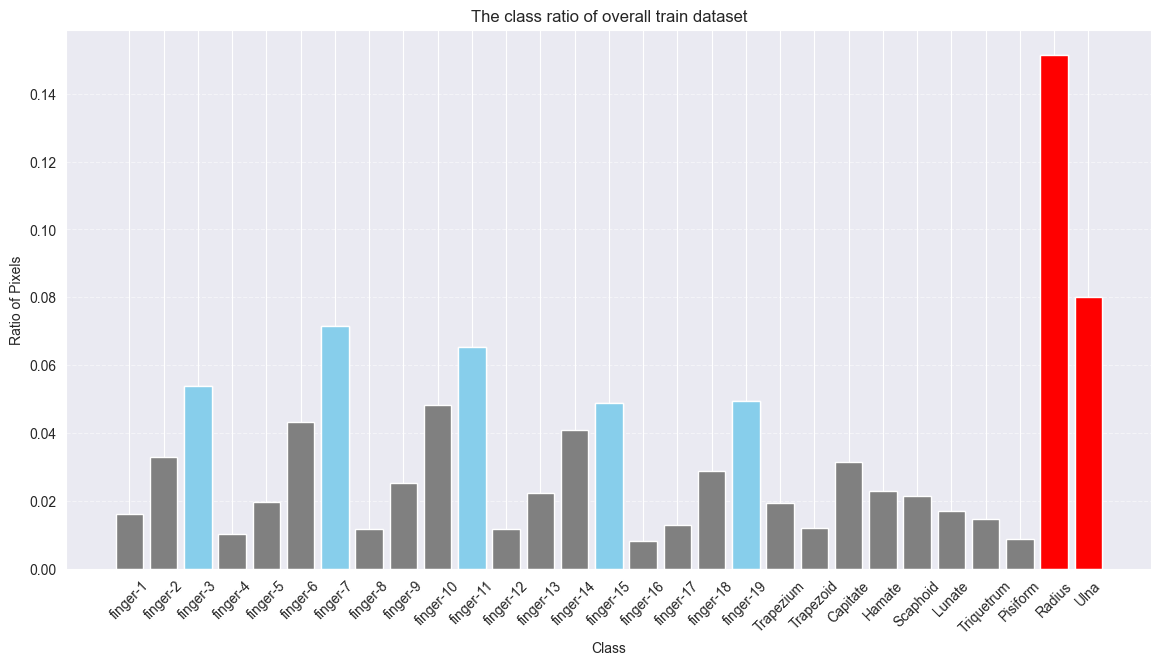

In [49]:
import matplotlib.pyplot as plt
import numpy as np

total_pixels_per_class = df_pixel.iloc[:, 1:].sum() 

total_pixels = total_pixels_per_class.sum()


class_ratios = total_pixels_per_class / total_pixels

plt.figure(figsize=(14, 7))
plt.bar(class_ratios.index, class_ratios.values, color=['gray' if i not in [2, 6, 10, 14, 18] else 'skyblue' for i in range(len(class_ratios))])

highlight_classes = [2, 6, 10, 14, 18]
for idx in highlight_classes:
    plt.bar(class_ratios.index[idx], class_ratios.values[idx], color='skyblue')

plt.bar('Radius', class_ratios['Radius'], color='red')
plt.bar('Ulna', class_ratios['Ulna'], color='red')

plt.title('The class ratio of overall train dataset')
plt.xlabel('Class')
plt.ylabel('Ratio of Pixels')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Train dataset 내 주요 Class에 대한 분포

- 팔 뼈는 특히 사람마다 차지하는 비율 차이가 존재함

- 사람마다 X-ray를 찍은 위치가 조금씩 다를 수 있음을 유의

- 그에 따라 Randius 기준으로 min, max 비교

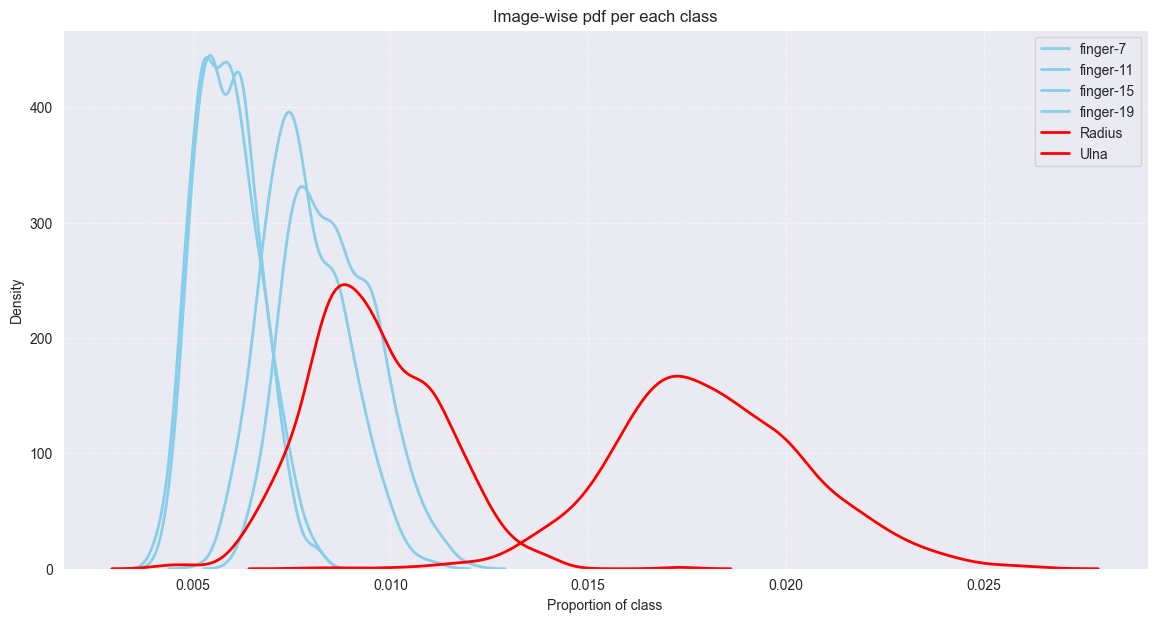

In [50]:
import matplotlib.pyplot as plt

# 주요 클래스 설정
highlight_classes = ['finger-7', 'finger-11', 'finger-15', 'finger-19', 'Radius', 'Ulna']
colors = {
    'finger-7': 'skyblue',
    'finger-11': 'skyblue',
    'finger-15': 'skyblue',
    'finger-19': 'skyblue',
    'Radius': 'red',
    'Ulna': 'red'
}
# 각 이미지에 대한 비율 계산
proportions = {cls: df_pixel[cls] / (2048 * 2048) for cls in highlight_classes}

# 그래프 그리기
plt.figure(figsize=(14, 7))

# 주요 클래스에 대한 밀도 함수 그래프
for cls in highlight_classes:
    sns.kdeplot(proportions[cls], label=cls,color=colors[cls], linewidth=2)

# 그래프 스타일 설정
plt.title('Image-wise pdf per each class')
plt.xlabel('Proportion of class')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 그래프 출력
plt.show()

In [51]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image
def picture(data):
    sample_data =data
    display(sample_data)
    image_name = sample_data['image_path'].iloc[0] 
    annotations = df[df['image_path'] == image_name]['annotations'].iloc[0]

    image_path = os.path.join(IMAGE_ROOT, image_name)
    image = cv2.imread(image_path)
    image = image / 255.

    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label

    label = label.transpose(2, 0, 1)

    label_rgb = label2rgb(label)  # 마스크를 RGB 이미지로 변환

    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image)  # 첫 번째 축에 이미지 표시
    ax[1].imshow(label_rgb)  # 두 번째 축에 레이블 표시
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()


,image_path,finger-1,finger-2,finger-3,finger-4,finger-5,finger-6,finger-7,finger-8,finger-9,...,Trapezium,Trapezoid,Capitate,Hamate,Scaphoid,Lunate,Triquetrum,Pisiform,Radius,Ulna
503,ID400\image1665539259135.png,9363,18440,34119,5994,10489,25345,44509,6916,14172,...,13898,7170,17959,14654,14692,12264,8258,6127,108952,59435


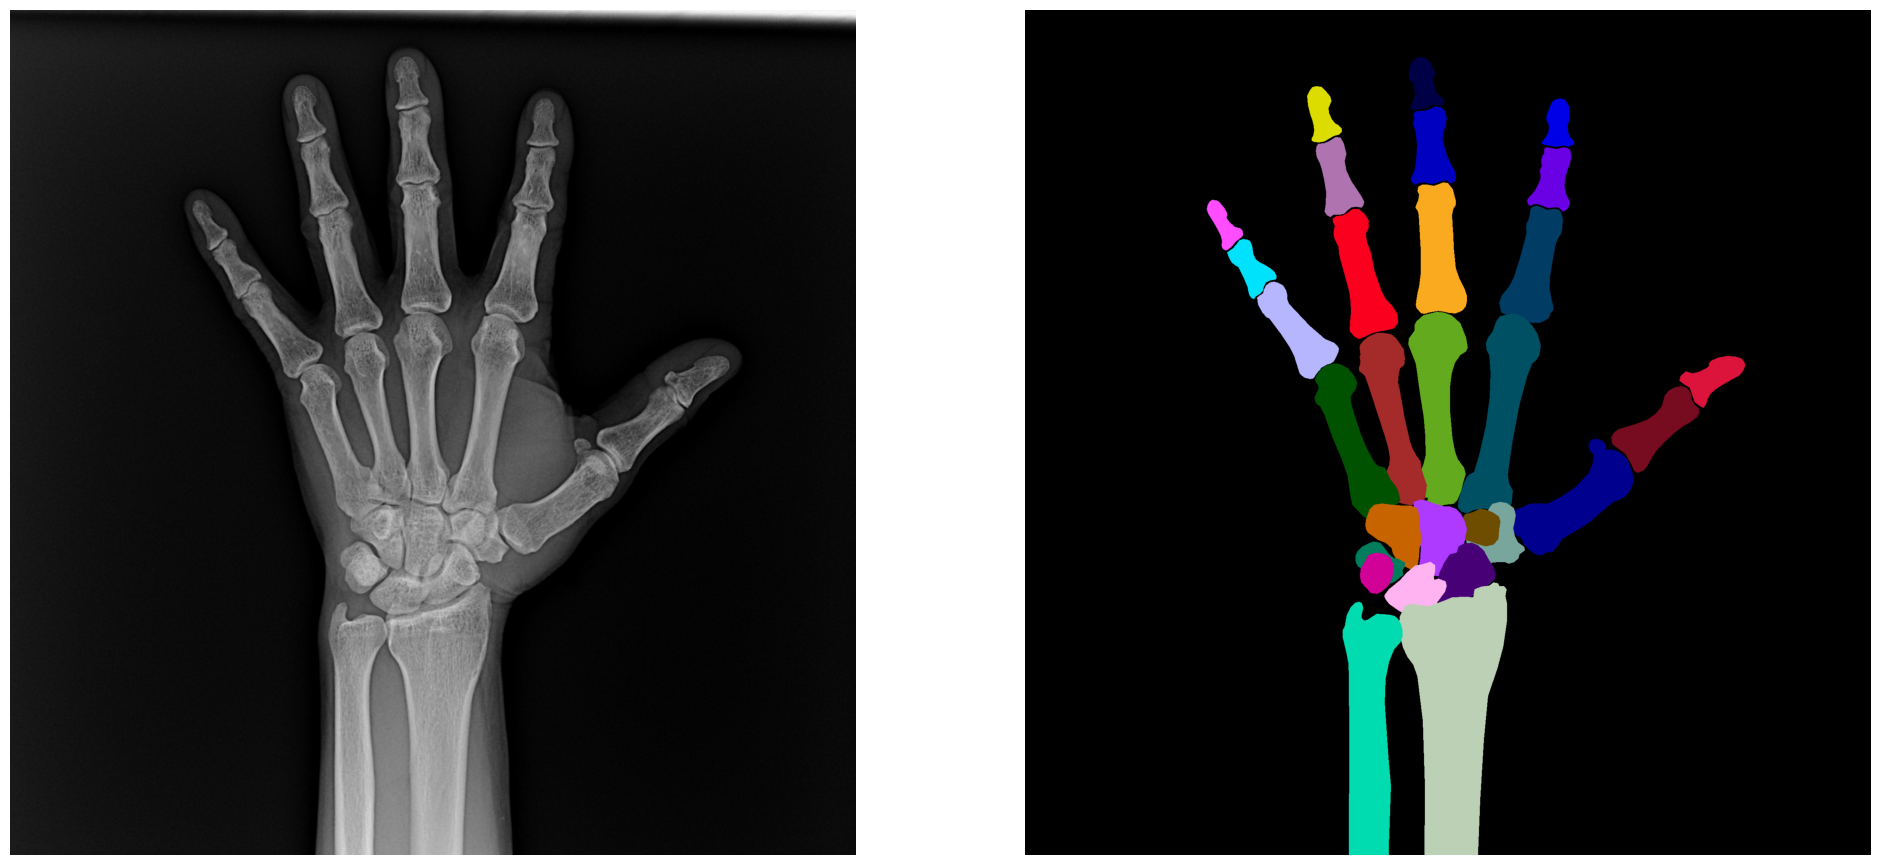

In [52]:
picture(df_pixel[df_pixel['Radius'] == 108952])

,image_path,finger-1,finger-2,finger-3,finger-4,finger-5,finger-6,finger-7,finger-8,finger-9,...,Trapezium,Trapezoid,Capitate,Hamate,Scaphoid,Lunate,Triquetrum,Pisiform,Radius,Ulna
95,ID058\image1661392103627.png,31796,19269,9336,5630,11599,24817,39555,6646,13981,...,14823,20211,7597,10206,8333,6524,10270,15391,35004,72589


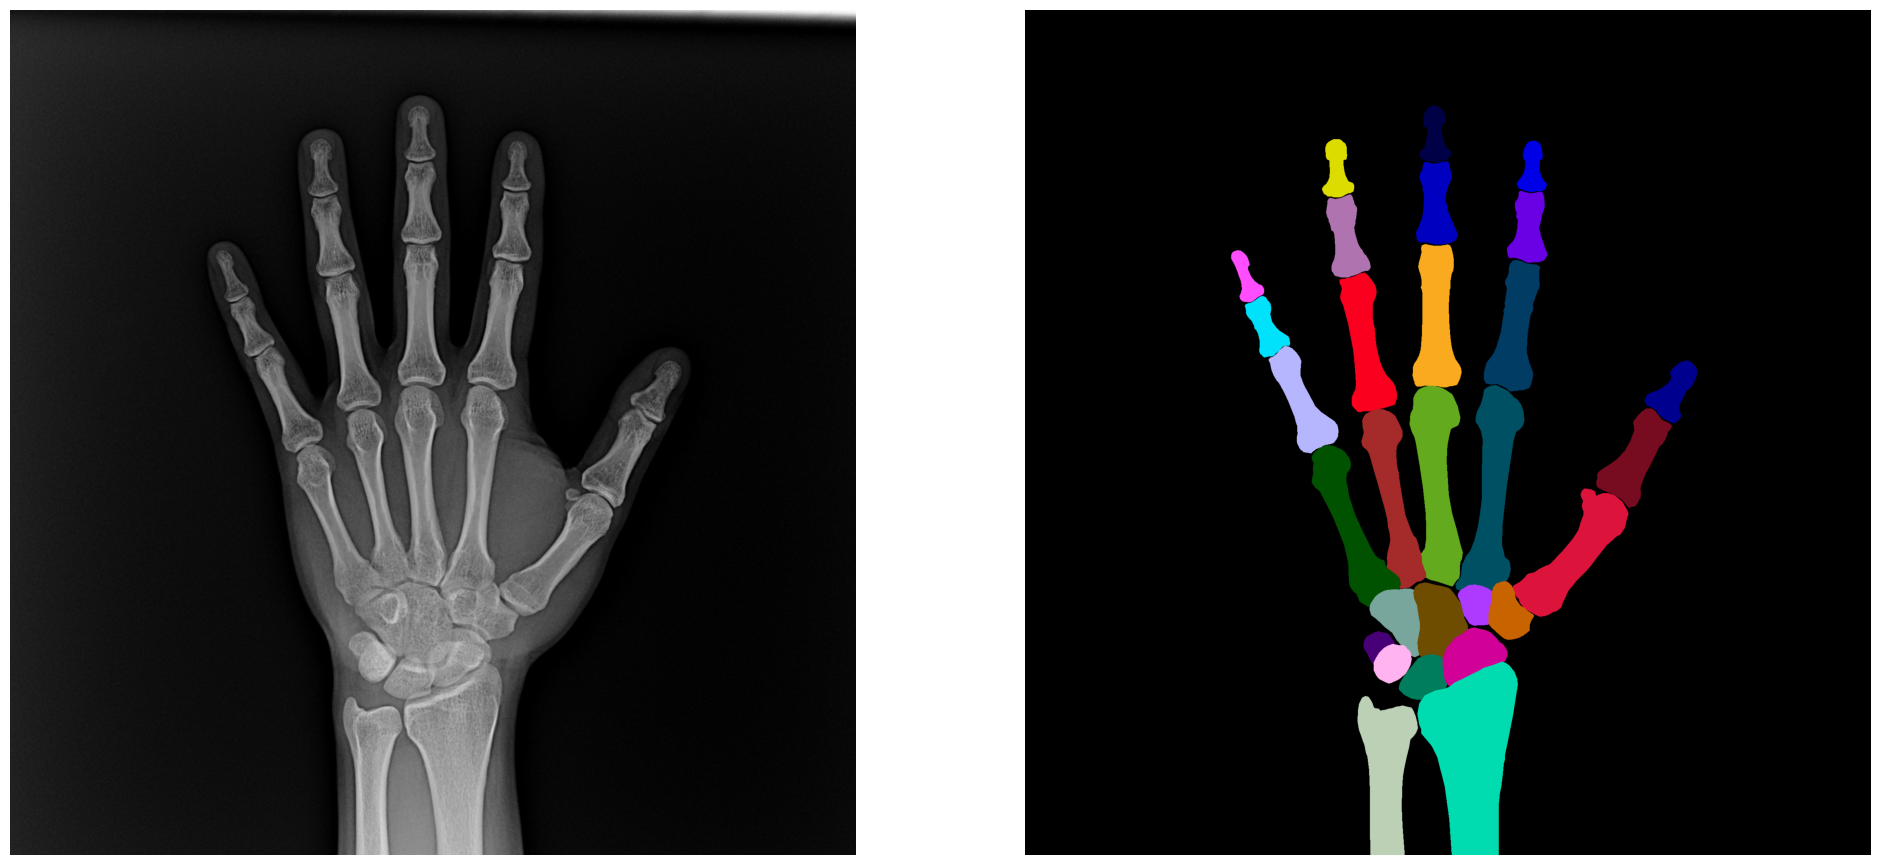

In [53]:
picture(df_pixel[df_pixel['Radius'] == 35004])

### 잘못된 라벨링

- 팔뼈 길이를 확인하기 위해서 시각화한 결과 라벨링이 잘못 되어 있다는 사실 발견

- 그 외에도 손등, 손가락등 여러 부분이 잘못 라벨링 되어 있다는 추가적인 사실 파악

- 데이터셋의 라벨링을 확인이 필요할 것


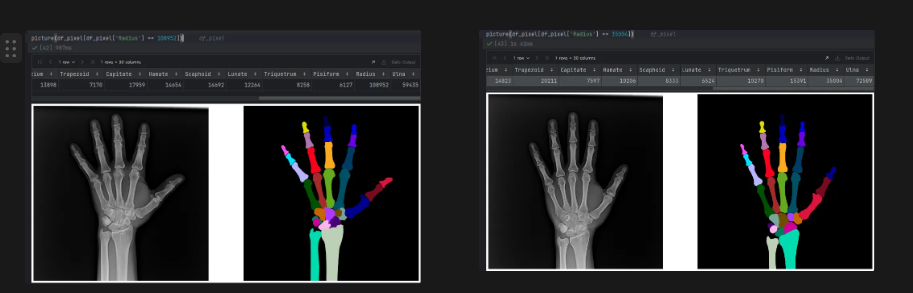




### 손등

- 학습된거 보니까 겹친 부위는 서로간에 차이가 조금 있음 

- 구조상 좀 더 뚜렷한 뼈가 더 잘 되는 느낌

- 경계선 테두리 같은걸 명확하게 하는걸 학습이랑 추론 동시에 적용하면 좀더 나을수도 있을까..

- 부정확한 라벨링 그에 따른 성능 전하

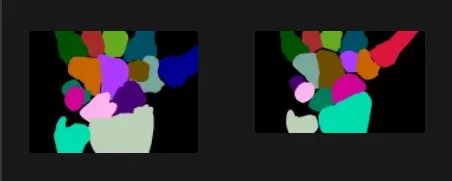


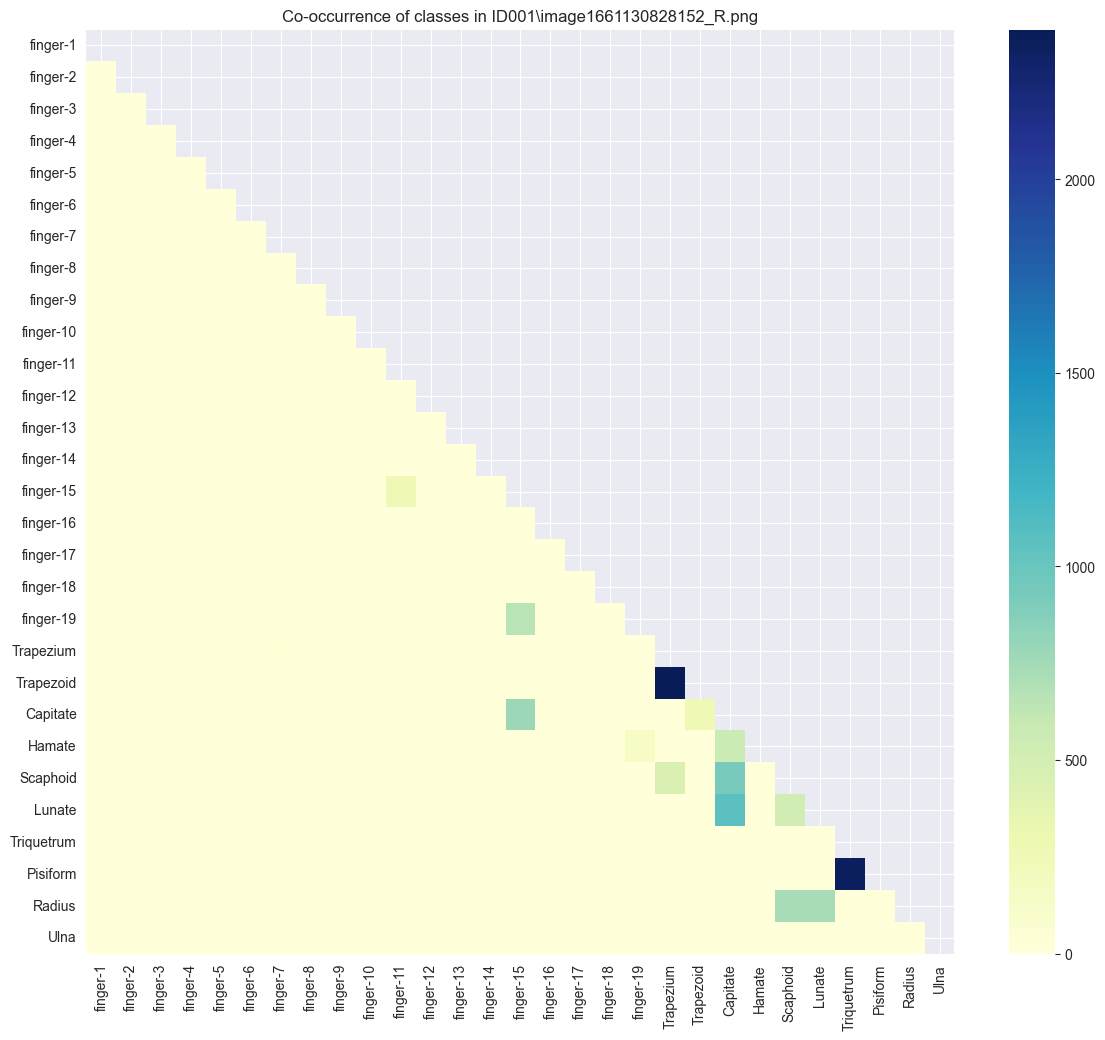

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 클래스 수와 이름 정의 (예: 'finger-1', 'finger-2', ..., 'Trapezium', ...)
num_classes = len(CLASSES)

# 동시 발생 행렬 초기화
co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

# 각 클래스별로 비교하여 동시 발생 카운트
for i in range(num_classes):
    for j in range(i + 1, num_classes):
        co_occurrence = np.logical_and(label[i] == 1, label[j] == 1)
        co_occurrence_matrix[i, j] = np.sum(co_occurrence)
        co_occurrence_matrix[j, i] = co_occurrence_matrix[i, j]  # 대칭 위치에도 값 복사

# 동시 발생 행렬을 데이터프레임으로 변환
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=CLASSES, columns=CLASSES)

# 하삼각행렬만 보이도록 마스크 생성
mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))

# 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(co_occurrence_df, mask=mask, annot=False, cmap='YlGnBu')
plt.title(f'Co-occurrence of classes in {image_name}')
plt.show()


### 클래스별 색상 평균

- 검은색에 가까울수록 옅다고 볼 수 있는데, 주로 가장자리 위치한 뼈 이면서 작은 뼈일수록 색이 옅다. 
- 반면 중심에 가깝고 크기가 큰 뼈 일수록 색이 진하다. 
- 학습과 추론시에 학습, 테스트 데이터 전처리로 옅은 클래스에 한해서 이런 밝기? 색상 부분을 좀더 진하게 바꿔주면 좀더 성능에 도움이 될 것이라고 생각한다.

In [ ]:
def calculate_class_color_means(dataset, num_classes):
    # 클래스별 R, G, B 채널 합계를 저장할 배열 초기화
    class_pixel_sum = np.zeros((num_classes, 3), dtype=np.float64)
    class_pixel_count = np.zeros(num_classes)

    # 데이터셋을 순회하며 클래스별 색상 합계와 픽셀 수를 계산
    for image, label in dataset:
        image_np = image.numpy().transpose(1, 2, 0) * 255  # 이미지 (H, W, C) 형식으로 변환 및 255 스케일 적용
        label_np = label.numpy().transpose(1, 2, 0)  # 라벨 (H, W, num_classes)

        # 각 클래스의 색상 평균 계산
        for class_idx in range(num_classes):
            class_mask = label_np[..., class_idx] > 0  # 해당 클래스의 마스크 생성
            if class_mask.sum() > 0:  # 해당 클래스 픽셀이 존재하는지 확인
                class_pixels = image_np[class_mask]  # 해당 클래스에 속하는 이미지 픽셀만 추출

                # 클래스별 색상 채널 합산 및 픽셀 수 계산
                class_pixel_sum[class_idx] += class_pixels.sum(axis=0)
                class_pixel_count[class_idx] += class_mask.sum()

    # 클래스별 색상 평균 계산
    class_color_means = {}
    for class_idx in range(num_classes):
        if class_pixel_count[class_idx] > 0:
            class_color_means[class_idx] = class_pixel_sum[class_idx] / class_pixel_count[class_idx]
        else:
            class_color_means[class_idx] = np.array([0, 0, 0])  # 픽셀이 없을 경우 [0, 0, 0]으로 설정

    return class_color_means

# 클래스별 색상 평균 계산
class_color_means = calculate_class_color_means(dataset, 29)
print("Class-wise Color Means:", class_color_means)

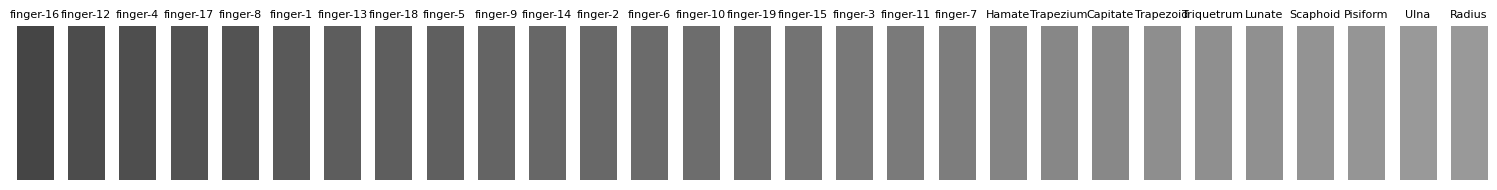

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the colors by grayscale intensity
sorted_class_colors = dict(sorted(class_color_means.items(), key=lambda item: np.mean(item[1])))

# Set up the plot
fig, axes = plt.subplots(1, len(sorted_class_colors), figsize=(15, 2))

# Plot each color as a small square in a row
for i, (class_id, color) in enumerate(sorted_class_colors.items()):
    axes[i].imshow([[np.array(color) / 255]], aspect='auto')
    axes[i].axis('off')
    # Use the corresponding name from CLASSES instead of the class ID
    axes[i].set_title(CLASSES[class_id], fontsize=8)

plt.tight_layout()
plt.show()

### 데이터셋 확인

- 트레인과 테스트 데이터셋 모두 회전된 형태의 손모양도 존재 

- 반지, 네일아트, 철심, 붕대 등 방해 요소가 있는 이미지는 제외하고 학습 진행

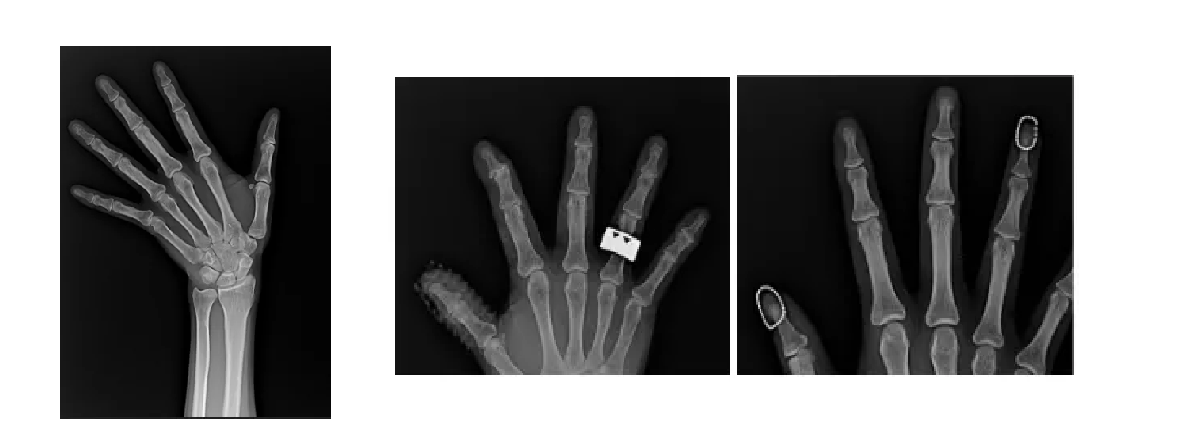